# Case 3: Linking gene mutations to imaging phenotype deviations

In this tutorial, we will translate the mouse gene mutation patterns to human, and calculate the individual risk score for autism by comparing the similarity between mutation patterns and individual deviation patterns.

## Introduction

- While mouse models enable direct investigation of gene-phenotype relationships, translating these findings to human clinical presentations remains challenging. Here, we demonstrate TransBrain's utility in bridging this gap, establishing an objective approach to link human imaging phenotypes with genetic mouse models in autism.

- [Deformation-based morphology (DBM)](https://www.fil.ion.ucl.ac.uk/spm/doc/books/hbf2/pdfs/Ch6.pdf) method was used to quantify regional volumes based on structural images. For mouse models, we quantified mutation-specific structural alterations by computing standardized volume differences (Cohen's d) between mutant and control groups. For human patients, we calculated the individual deviation through a normative model (see **Methods** section of our [paper](https://www.biorxiv.org/content/10.1101/2025.01.27.635016v2.abstract)).

- [Normative Modeling](https://pubmed.ncbi.nlm.nih.gov/35650452/) approach characterizes atypical brain features by comparing each individual against a statistical model of typical brain development, to quantify region-specific brain volume deviations.


### Data

- Autism mouse models image: ([link](https://www.braincode.ca/content/public-data-releases#dr001))

- Human ABIDE I data: ([link](https://fcon_1000.projects.nitrc.org/indi/abide))

- Pre-saved data: ([link](https://github.com/ibpshangzheng/Transbrain/tree/main/tutorials/notebooks/translation/autism_mutation))


In [17]:
import pandas as pd
import numpy  as np
from nilearn import image,plotting
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import pickle
import os
import transbrain as tb
import matplotlib.image as mpimg
from PIL import Image

The pipeline is shown in the figure below.

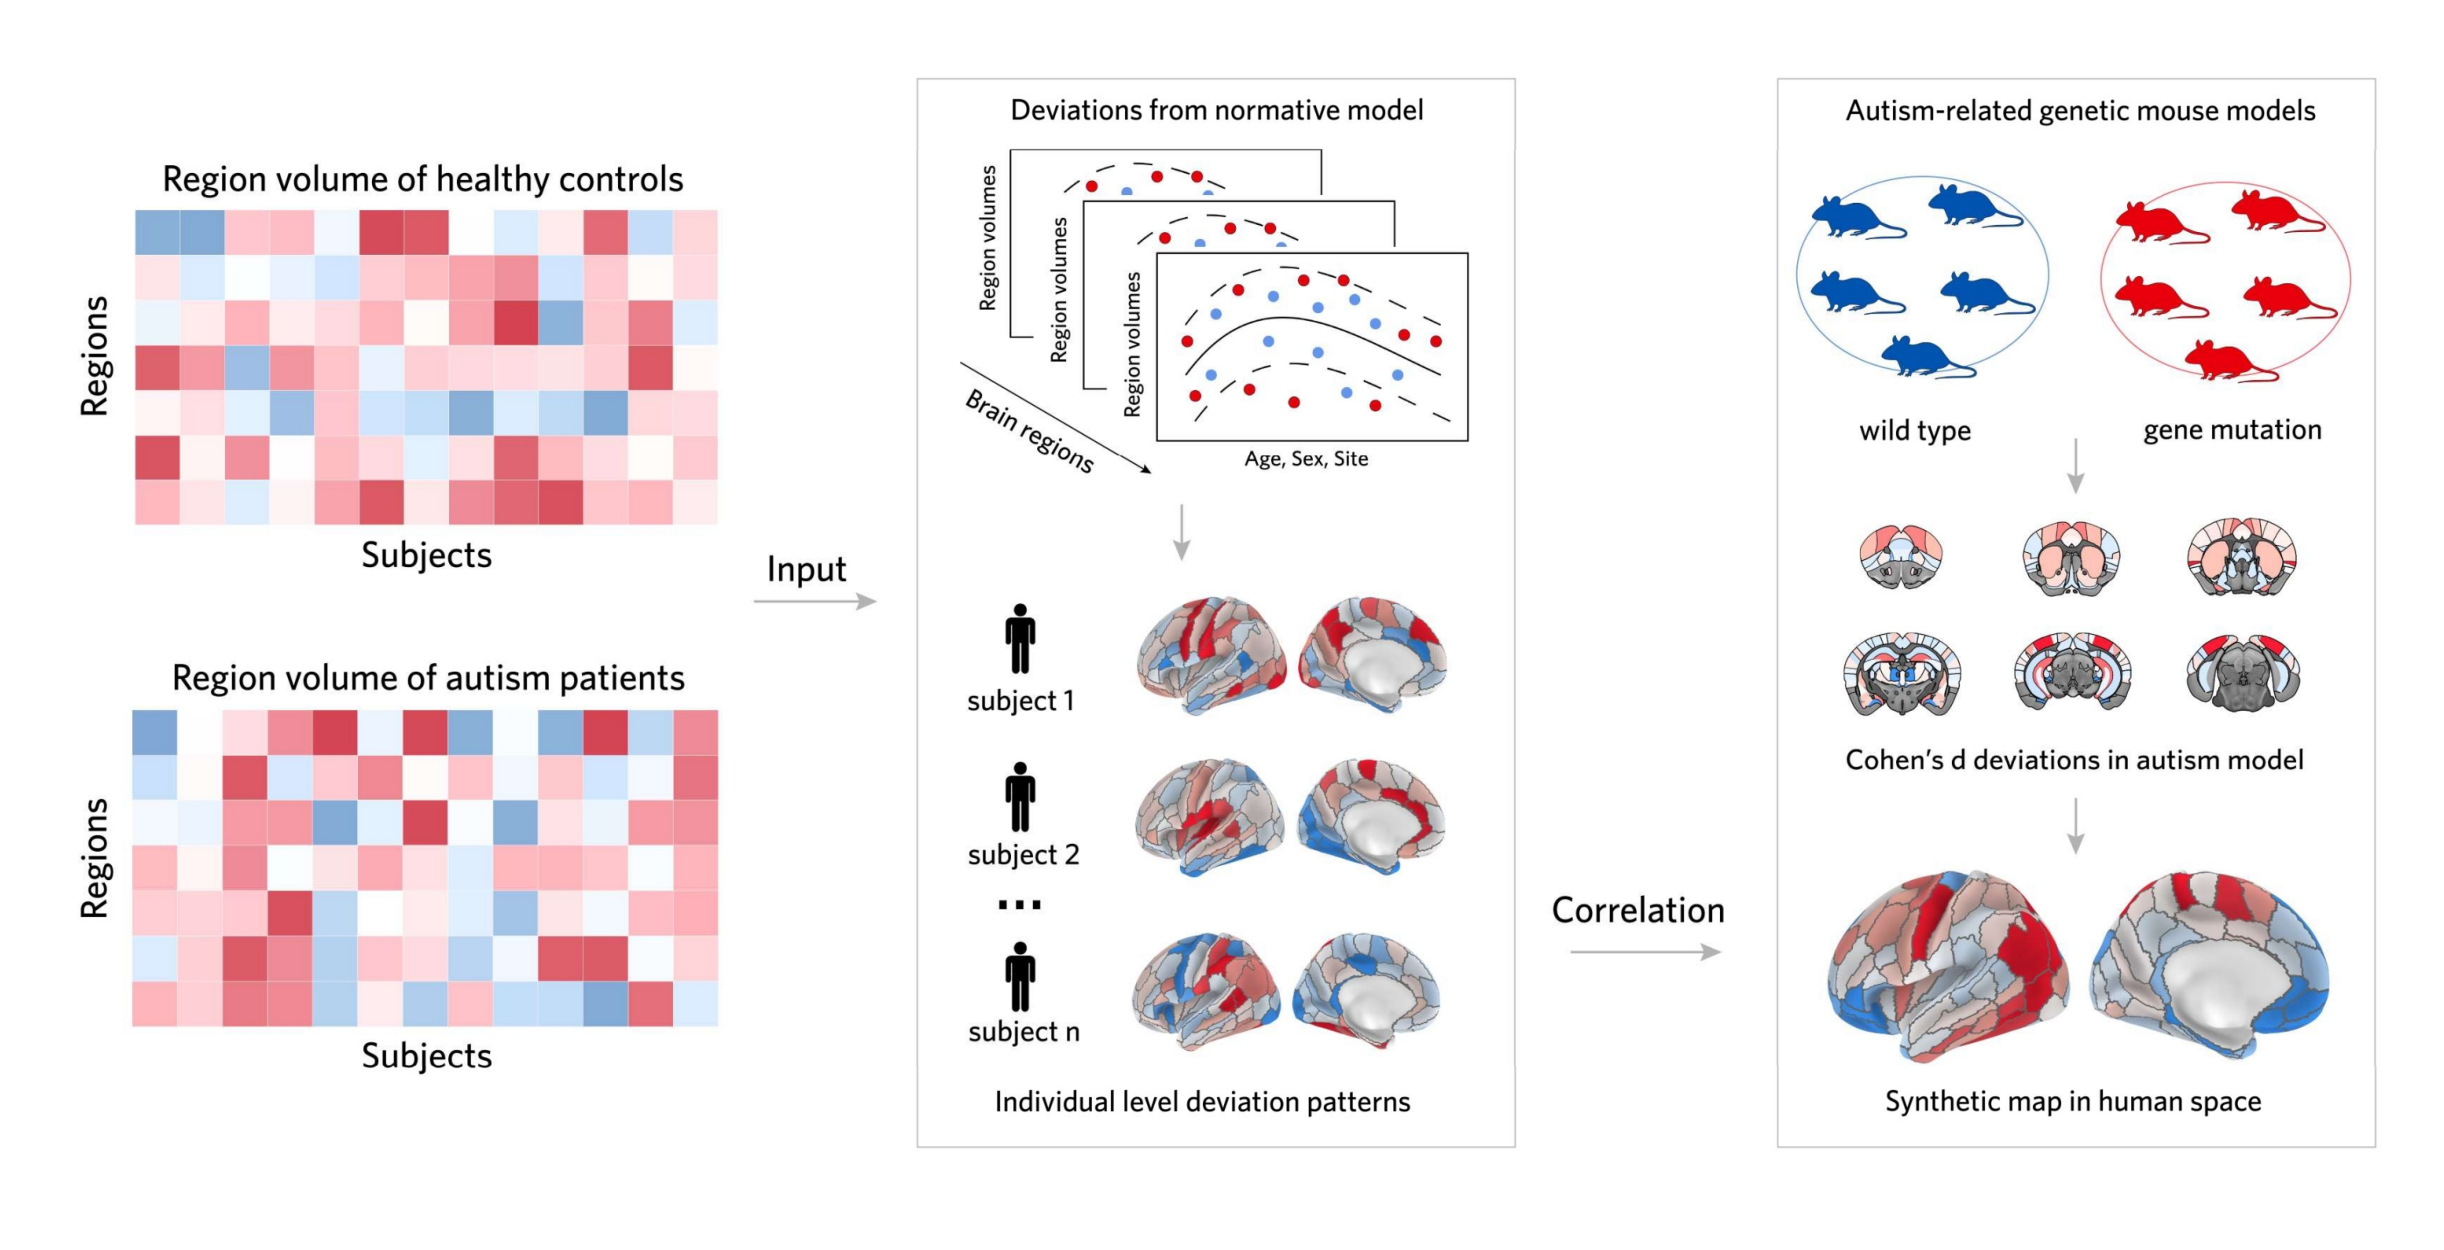

In [18]:
img_path = './case3.png'
img = Image.open(img_path)
plt.figure(figsize=(5, 4), dpi=600)
plt.imshow(img)
plt.axis('off') 
plt.show()

Load pre-saved deviation pattern in autistic individuals

In [19]:
human_deviation_pattern = pd.read_csv('z_autism_regress.csv',index_col=0)

In [20]:
human_deviation_pattern

,A8m,A8dl,A9l,A6dl,A6m,A9m,A10m,A9/46d,IFJ,A46,...,external segment of globus pallidus,internal segment of globus pallidus,mPMtha,Stha,cTtha,Otha,mPFtha,lPFtha,rTtha,PPtha
sub-0050952,-0.034057,1.059806,0.724692,-0.340610,-0.249368,0.238761,1.144679,1.313394,1.047292,0.545816,...,-0.450980,-0.752422,-0.095561,-0.190090,0.265504,-0.768822,0.194435,0.198131,1.098208,-0.074526
sub-0050953,1.061673,-0.160178,-0.068777,0.944350,3.148085,-0.321584,0.553024,0.516878,0.188200,0.080396,...,-0.048533,0.935241,1.024679,0.396401,0.362188,0.023422,0.584330,0.352479,0.795874,0.402062
sub-0050954,-0.432803,-0.113471,-0.611091,0.124712,0.004385,-0.589163,-0.993235,-1.752840,-1.815323,-2.023047,...,-0.324200,-0.293174,-0.687647,-0.874022,-1.322410,-1.489044,-0.965495,-0.945318,-1.032023,-1.243394
sub-0050955,-0.070320,0.029972,0.091655,-0.151066,0.433888,0.645881,-0.032037,0.549623,-0.423663,-0.435905,...,0.633728,0.234445,0.304456,-0.456908,-0.125732,-0.519848,0.282118,-0.009059,0.395863,-0.407659
sub-0050956,-0.412015,-1.041933,-1.429265,-0.609115,1.011669,-0.840085,-0.984241,-1.792197,-0.566550,-1.237900,...,-0.292711,-0.183103,-0.250089,0.213175,-1.428655,0.074822,-0.543420,-0.607728,-1.319575,-0.461133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-0050528,1.035161,0.756369,0.388294,0.181055,1.090050,1.949932,1.032400,-0.903074,0.550083,1.206374,...,2.191379,2.394034,2.524151,2.898222,1.758949,2.683350,2.608460,2.846178,1.350955,2.866482
sub-0050529,-0.110055,0.485214,0.444477,1.358316,2.073944,0.373068,0.271459,1.067132,-0.572745,1.304335,...,-1.992659,-2.169547,-2.450559,-1.997179,-0.558258,-0.591224,-0.320817,-1.024496,-0.262824,-1.297364
sub-0050530,0.656295,-0.192291,-0.016519,-0.512045,-0.287378,0.236851,-0.809093,0.389524,-0.393176,0.924101,...,0.129328,0.824507,1.093574,0.148122,0.104102,-0.856385,-0.256846,0.165303,-0.490654,0.127829
sub-0050531,-0.644894,-1.742284,-1.331522,-2.276827,-1.963632,-1.314368,-0.845506,-1.498217,-0.785925,-1.494833,...,-2.560121,-2.548655,-1.999179,-1.404668,-1.804419,-1.573512,-2.061807,-2.343362,-2.024985,-1.656952


Load pre-saved deviation patterns in autism mouse models.

In [21]:
mouse_mutation_pattern = pd.read_csv('magel2_mutation_pattern.csv', index_col=0) 

In [22]:
mouse_mutation_pattern 

,Magel2
ACAd,-1.690432
ACAv,-2.476901
PL,-2.639617
ILA,-2.553695
ORBl,-2.469451
...,...
MTN,-2.144638
ILM,-2.382645
GENv,-0.346842
EPI,-1.912796


## Translating mouse mutation patterns to human

Using TransBrain, we can translate the mutation patterns from mouse models to humans and compare them with human deviation patterns.

In [23]:
Transformer = tb.trans.SpeciesTrans('bn')

INFO:root:Initialized for bn atlas.


In [24]:
help(Transformer.mouse_to_human)

Help on method mouse_to_human in module transbrain.trans:

mouse_to_human(phenotype: pandas.core.frame.DataFrame, region_type: Literal['cortex', 'subcortex', 'all'] = 'cortex', normalize: bool = True, restore: bool = False) -> pandas.core.frame.DataFrame method of transbrain.trans.SpeciesTrans instance
    Translate mouse phenotype to human.
    
    Parameters
    ----------
    phenotype : pd.DataFrame
        Mouse phenotype DataFrame (regions × phenotypes).
    region_type : {'cortex', 'subcortex', 'all'}, optional
        The brain region type to translate. Default is 'cortex'.
    normalize : bool, optional
        Whether to normalize data before translation. Default is True.
    restore : bool, optional
        Whether to restore values back to original scale after translation. Only used if normalize is True.
        Please enable this parameter with caution, unless you are certain that the distributions of this phenotype are consistent between the two species.
    
    Returns

In [25]:
mutation_trans_in_human = Transformer.mouse_to_human(mouse_mutation_pattern,region_type='all')

INFO:root:Successfully translated mouse all phenotypes to human.


## Calculate individual gene risk score

In [26]:
cross_species_autism_dataframe = pd.DataFrame()

for i in range(human_deviation_pattern.shape[0]):
    
    row_data = human_deviation_pattern.iloc[i].values
    corr_l = []
    
    m_data = np.squeeze(mutation_trans_in_human.values)
    corr_ = stats.pearsonr(row_data,m_data)[0]
    corr_l.append(corr_)

    cross_species_autism_dataframe[i] = corr_l

cross_species_autism_dataframe = cross_species_autism_dataframe.T
cross_species_autism_dataframe.index = human_deviation_pattern.index
cross_species_autism_dataframe.columns = mutation_trans_in_human.columns.values

Finally, we obtain the risk score for each individual.

In [28]:
cross_species_autism_dataframe

,Magel2
sub-0050952,-0.027680
sub-0050953,-0.153618
sub-0050954,-0.053774
sub-0050955,0.269008
sub-0050956,-0.091962
...,...
sub-0050528,-0.097262
sub-0050529,-0.045961
sub-0050530,0.086125
sub-0050531,0.127681
